In [18]:
import geopandas
import pandas as pd
from osgeo import ogr,gdal
import os
import numpy 
from tqdm import tqdm
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt

gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 


def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}

def landuse(osm_path):
    """
    Function to extract land-use polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.    
    """    
    return(retrieve(osm_path,'multipolygons',['landuse']))

def buildings(osm_path):
    """
    Function to extract building polygons from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique building polygons.    
    """
    return retrieve(osm_path, 'multipolygons',['building','amenity'])

def roads(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """   
    return retrieve(osm_path,'lines',['highway']) 
 
#def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    #return retrieve(osm_path,'lines',['railway','service'],**{"service":[" IS NOT NULL"]})

def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def train_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['man_made'],**{'man_made':["='communications_tower'"]})).rename(columns={'man_made': 'asset'})

def subway_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway'],**{'railway':["='subway_entrance'"]}))

def tram_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='tram_stop'"]}))

def ferries(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """
    return retrieve(osm_path,'lines',['route'],**{"route":["='ferry'",]})

def electricity(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.   
    """    
    return retrieve(osm_path,'lines',['power','voltage']) #,**{'voltage':[" IS NULL"],}

def mainRoads(osm_path):
    """
    Function to extract main road linestrings from OpenStreetMap    
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique main road linestrings.   
    """ 
    return retrieve(osm_path,'lines',['highway','oneway','lanes','maxspeed'],**{'highway':["='primary' or ","='trunk' or ","='motorway' or ","='trunk_link' or ",
                    "='primary_link' or ", "='secondary' or ","='tertiary' or ","='tertiary_link'"]})


def remove_overlap_openstreetmap(gdf):
    """
    Function to remove overlap in polygons in from OpenStreetMap.
    
    Arguments:
        *gdf* : a geopandas GeoDataFrame with all unique railway linestrings.
        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with (almost) non-overlapping polygons.
    
    """
    
    gdf['sq_area'] = gdf.area

    new_landuse = []
    for use in tqdm(gdf.itertuples(index=False),total=len(gdf),desc='Get unique shapes'):
        use_geom = use.geometry
        matches = gdf.loc[list(gdf.sindex.intersection(use.geometry.bounds))]
        for match in matches.itertuples(index=False):
            if use.sq_area > match.sq_area:
                use_geom = use_geom.difference(match.geometry)
        new_landuse.append([use.osm_id,use.landuse,use_geom])

    new_gdf  =  geopandas.GeoDataFrame(pandas.DataFrame(new_landuse,columns=['osm_id','landuse','geometry'])) 
    new_gdf.crs = {'init' : 'epsg:4326'}
    return new_gdf


def extract_value_other_gdf(x,gdf,col_name):
    """
    Function to extract value from column from other GeoDataFrame
    
    Arguments:
        *x* : row of main GeoDataFrame.
        
        *gdf* : geopandas GeoDataFrame from which we want to extract values.
        
        *col_name* : the column name from which we want to get the value.
        
    
    """
    try:
        return gdf.loc[list(gdf.sindex.intersection(x.geometry.bounds))][col_name].values[0]
    except:
        return None

def get_losses(x,damage_curves,damage_values):
    """
    Function to estimate the damages.
    
    Arguments:
        *x* : row of main GeoDataFrame
        
        *damage_curves*: pandas DataFrame of curves. Inundation depths should be the index.
        
        *damage_values*: dictionary with maximum damage values.
        
    Returns:
        
        Total damage for the given land-use object.
    
    """
    
    return numpy.interp(x.depth,list(damage_curves.index),list(damage_curves[x.landuse]))*damage_values[x.landuse]*x.area_m2

In [19]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [20]:
train_stations(osm_data)  

,osm_id,railway,name,geometry
0,46199966,station,Diemen Zuid,POINT (4.95606 52.33026)
1,250222266,station,Amstelveenseweg,POINT (4.85758 52.33840)
2,250224485,station,Jan van Galenstraat,POINT (4.83529 52.37266)
3,250233810,station,Amsterdam Holendrecht,POINT (4.96017 52.29799)
4,289445435,station,Van der Madeweg,POINT (4.93052 52.32945)
5,427565080,station,Overamstel,POINT (4.91763 52.33173)
6,1633149045,station,Halfweg-Zwanenburg,POINT (4.74687 52.38598)
7,2237721918,station,De Vlugtlaan,POINT (4.83822 52.37961)
8,3938547498,station,Amsterdam Sloterdijk,POINT (4.83811 52.38903)
9,4005961975,station,Amsterdam Bijlmer ArenA,POINT (4.94709 52.31224)


<AxesSubplot: >

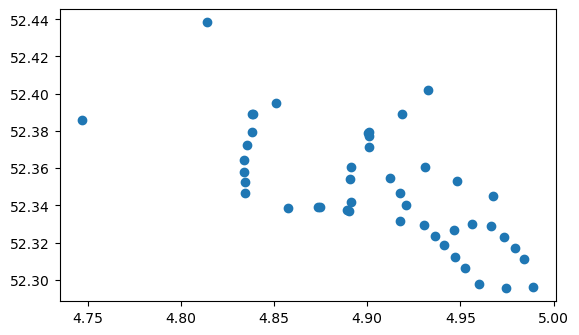

In [4]:
df_trainsta = train_stations(osm_data)
df_trainsta.plot() # if it can show geometry or osm_id  label = 'osm_id'???????????

In [6]:
import openpyxl

In [7]:
df_trainsta.to_excel('./train_stations.xlsx',header = True, index = False,sheet_name = 'mydata')

<AxesSubplot: >

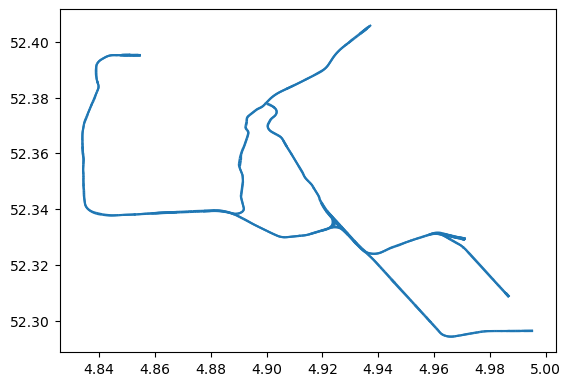

In [8]:
railway(osm_data)
df_railway = railway(osm_data)
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

In [9]:
subway.to_excel('./subway.xlsx',header = True, index = False,sheet_name = 'mydata')

<AxesSubplot: >

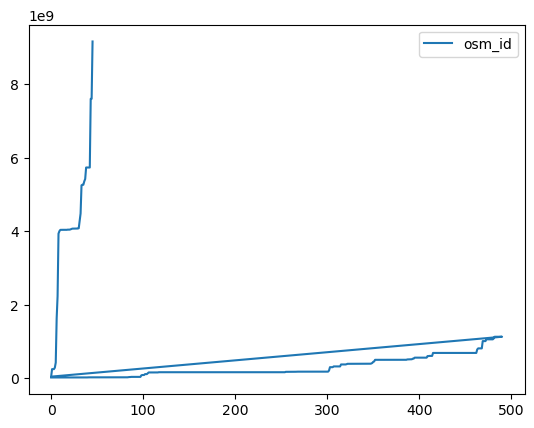

In [21]:
# Try to draw the nodes and lines together???????????   Didn't work, change another way
df1 = pd.read_excel(r'./subway1.xlsx','sheet1')
df2 = pd.read_excel(r'./subway2.xlsx','sheet1')
frames = [df1,df2]
df = pd.concat(frames)
df.to_excel('./subwayall.xlsx',header = True, index = False)
df.plot()   

In [12]:
#Creat amsterdam subway with NetworkX
import networkx as nx

In [13]:
df = pd.read_excel(r'./amsub.xlsx','od_net_undirected')

In [14]:
G = nx.from_pandas_edgelist(df, 'origin', 'destination', create_using = nx.Graph()) # unweighted

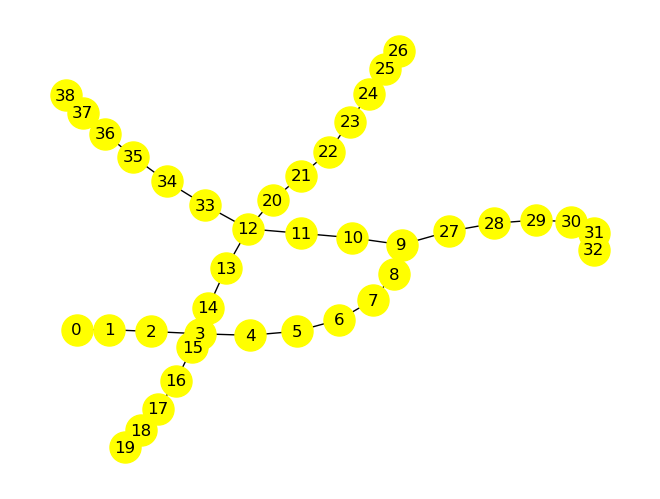

In [15]:
nx.draw(G, node_size = 500, node_color = 'yellow', with_labels = True)

In [16]:
WG = nx.from_pandas_edgelist(df, 'origin', 'destination','weight', create_using = nx.Graph()) # weighted - random running time as weight 

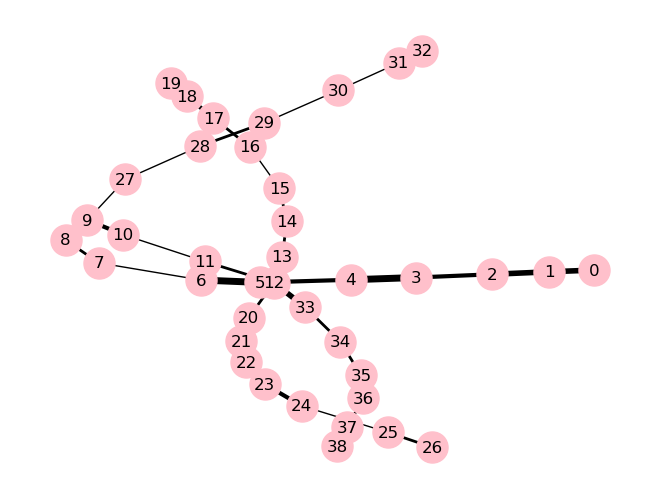

In [17]:
edge_width = nx.get_edge_attributes(WG, "weight")
nx.draw(WG, node_size = 500, node_color = 'pink', with_labels = True, width = list(edge_width.values()))

### 1.retrive *name* together with *osm_id* *railway* *geometry*  
### 2.automatically get OD pair (by drawing nodes and edges together)
### 3.*train_stations(osm_data)* contains subway stations and railway stations有时候因为站点是线条或区域格式而提取不到
### 4.how to draw different routes